GT4Py - GridTools for Python

Copyright (c) 2014-2022, ETH Zurich
All rights reserved.

This file is part the GT4Py project and the GridTools framework.
GT4Py is free software: you can redistribute it and/or modify it under
the terms of the GNU General Public License as published by the
Free Software Foundation, either version 3 of the License, or any later
version. See the LICENSE.txt file at the top-level directory of this
distribution for a copy of the license or check <https://www.gnu.org/licenses/>.

SPDX-License-Identifier: GPL-3.0-or-later

To run this notebook on gpubox
```
source platforms/mom6/builds/lscgpu50/gnu11.env;export MPICC=$(which mpicc);export BOOST_ROOT=/home/Niki.Zadeh/BOOST/ROOT/boost_1_79_0; export CUDA_VISIBLE_DEVICES=0,1;conda activate gt4pyenv; jupyter notebook --no-browser
```

## Horizontal Diffusion Example

### Imports and utilities

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import gt4py.storage
import gt4py.gtscript as gtscript

### Global definitions

In [2]:
backend = "gt:gpu"  # options: "numpy", "gt:cpu_ifirst", "gt:cpu_kfirst", "gt:gpu", "dace:cpu", "dace:gpu"
dtype = np.float64

### Define GTScript stencil

In [3]:

@gtscript.stencil(backend) # this decorator triggers compilation of the stencil
def horizontal_diffusion(
    in_field: gtscript.Field[dtype],
    out_field: gtscript.Field[dtype],
    coeff: gtscript.Field[dtype],
):
    with computation(PARALLEL), interval(...):
        lap_field = 4.0 * in_field[0, 0, 0] - (
            in_field[1, 0, 0] + in_field[-1, 0, 0] + in_field[0, 1, 0] + in_field[0, -1, 0]
        )
        res = lap_field[1, 0, 0] - lap_field[0, 0, 0]
        flx_field = 0 if (res * (in_field[1, 0, 0] - in_field[0, 0, 0])) > 0 else res
        res = lap_field[0, 1, 0] - lap_field[0, 0, 0]
        fly_field = 0 if (res * (in_field[0, 1, 0] - in_field[0, 0, 0])) > 0 else res
        out_field = in_field[0, 0, 0] - coeff[0, 0, 0] * (
            flx_field[0, 0, 0] - flx_field[-1, 0, 0] + fly_field[0, 0, 0] - fly_field[0, -1, 0]
        )


### Initialize Fields

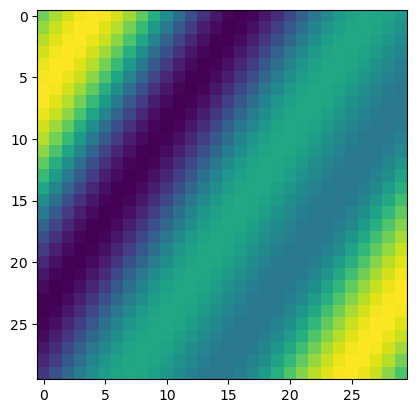

In [4]:
# Initialize example data
N = 30
shape = (N, N, N)
origin = (2, 2, 0)

indices = np.arange(N)
ii = np.zeros((N, N, N)) + np.reshape(indices, (N, 1, 1))
jj = np.zeros((N, N, N)) + np.reshape(indices, (1, N, 1))
kk = np.zeros((N, N, N)) + np.reshape(indices, (1, 1, N))

xx = ii / N
yy = jj / N
zz = kk / N

in_data = 5. + 8. * (2. + np.cos(np.pi * (xx + 1.5 * yy)) + np.sin(2 * np.pi * (xx + 1.5 * yy))) / 4.
out_data = np.zeros(shape)
coeff_data = 0.025 * np.ones(shape)

# Plot initialization
projection = np.array(np.sum(in_data, axis=2))
plt.imshow(projection)


### Copy input data from numpy arrays to gt4py storages


In [5]:
in_storage = gt4py.storage.from_array(
    in_data, dtype, backend=backend, aligned_index=origin
)
out_storage = gt4py.storage.from_array(
    out_data, dtype, backend=backend, aligned_index=origin
)
coeff_storage = gt4py.storage.from_array(
    coeff_data, dtype, backend=backend, aligned_index=origin
)

### Run computation

In [6]:
horizontal_diffusion(in_storage, out_storage, coeff_storage, origin=origin)

In [7]:
import time
start_time = time.time()

for i in range(1000000):
    horizontal_diffusion(in_storage, out_storage, coeff_storage, origin=origin)

print("\n- Running time: ", time.time() - start_time )

#backend='gt:gpu' - Running time:    51.94952321052551
#backend="gt:cpu_ifirst" - Running time:  62.49137759208679
#backend="gt:cpu_kfirst" - Running time: 73.71631145477295
#backend='numpy'  - Running time:  2124.6681759357452


- Running time:  52.733251094818115


### Timings
|backend |  Runtime on gpubox |
| :-  |  -: |
| gt:gpu | 51.95 |
| gt:cpu_ifirst | 62.49 |
| gt:cpu_kfirst | 73.72 |
|  numpy | 2124.67 |

### Plot results

In [8]:
#projection = np.asarray(np.sum(out_storage, axis=2))
#plt.imshow(projection)